In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import auc, roc_curve,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

**Assessment methods**

In [2]:
def show_confusion_matrix(y,y_pred,labels):
    matrix = confusion_matrix(y_true=y,y_pred=y_pred,labels=labels)
    plt.matshow(matrix)
    plt.colorbar()
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.xticks(np.arange(matrix.shape[1]),labels)
    plt.yticks(np.arange(matrix.shape[1]),labels)
    plt.show()

In [3]:
def show_curve(x_axis,y_axis,xLabel="test_set_size",yLabel="accurancy"):
    plt.plot(x_axis,y_axis)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

In [4]:
def train_model(model,X_train,y_train,X_test,y_test,labels):
    # print('training model...')
    model.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = f1_score(y_true=y_test,y_pred=y_pred,labels=labels,average="macro")
    print('accuracy is: ', accuracy,', F1 score is: ',f1)
    # show_confusion_matrix(y_test,y_pred,labels)
    return accuracy,f1

In [5]:
def transTime(split):
    split = split.split("/")
    split[1], split[0] = split[0], split[1]
    split = "/".join(split)
    return split

Transfer two datetime into time interval.

In [6]:
def getInterval(arrayLike):
    launched = transTime(arrayLike["launched"])
    deadline = transTime(arrayLike["deadline"])
    interval = pd.to_datetime(deadline)-pd.to_datetime(launched)
    return interval.days

In [7]:
def trans_category(arrayLike):
    cat_dic = []
    main_dic = []
    assert(arrayLike is not None)
    category = arrayLike["category"]
    main_category = arrayLike["main_category"]
    for ele in category:
        if ele not in cat_dic:
            cat_dic.append(ele)
    for ele in main_category:
        if ele not in main_dic:
            main_dic.append(ele)     
    return cat_dic, main_dic      

Impute all categoricial values into numbers.

In [8]:
def trans_currency(arrayLike):
    curr_dic = []
    currency = arrayLike["currency"]
    for ele in currency:
        if ele not in curr_dic:
            curr_dic.append(ele)
    return curr_dic

In [9]:
def trans_country(arrayLike):
    country_dic = []
    country = arrayLike["country"]
    for ele in country:
        if ele not in country_dic:
            country_dic.append(ele)
    return country_dic

In [10]:
def label_generate(arrayLike):
    label = []
    country = arrayLike["state"]
    for ele in country:
        if ele not in label:
            label.append(ele)
    return label

**Data pre-processing contains follow steps:**
 - drop ID and name, since they are unique value for each one.
 - fil null values with median value.
 - calculate time interval.
 - extract the state as label set.

In [11]:
missing_values = ["N,0\""]
dataset = pd.read_csv("kickstarter201801.csv",)
dataset = dataset.drop(["ID","name"],axis=1)
dataset["usd pledged"].fillna(0,inplace = True)
dataset["earning"] = dataset.apply(lambda x:x['usd_pledged_realised at deadline']-x['usd_goal_real_at_start'],axis=1)
dataset = dataset.drop(['usd_pledged_realised at deadline','usd_goal_real_at_start'],axis=1)


In [12]:
dataset["interval"] = dataset.apply(getInterval,axis=1)
dataset = dataset.drop(["deadline","launched"],axis=1)
cat_dic, main_dic = trans_category(dataset)
dataset["category"] = dataset["category"].apply(lambda x: cat_dic.index(x))
dataset["main_category"] = dataset["main_category"].apply(lambda x: main_dic.index(x))
curr_dic = trans_currency(dataset)
dataset["currency"] = dataset["currency"].apply(lambda x: curr_dic.index(x))
country_dic = trans_country(dataset)
dataset["country"] = dataset["country"].apply(lambda x: country_dic.index(x))
state_dic = label_generate(dataset)
y = dataset["state"].apply(lambda x: state_dic.index(x))
dataset = dataset.drop(["state"],axis=1)
state_dic=[0,1,2,3,4,5]
# print(dataset)

**Then we can split train and test set. To make prediction more accurate, we choose three types of classifier: KNN, GaussianNB and random forest. Affect of hyperparameters to the result will be shown in matrix below.**

In [18]:
dataset

,category,main_category,currency,goal,pledged,backers,country,usd pledged,earning,interval
0,0,0,0,1000.0,0.0,0,0,0.0,-1533.95,58
1,1,1,1,30000.0,2421.0,15,1,100.0,-27579.00,59
2,1,1,1,45000.0,220.0,3,1,220.0,-44780.00,44
3,2,2,1,5000.0,1.0,1,1,1.0,-4999.00,29
4,3,1,1,19500.0,1283.0,14,1,1283.0,-18217.00,55
...,...,...,...,...,...,...,...,...,...,...
378656,8,1,1,50000.0,25.0,1,1,25.0,-49975.00,29
378657,1,1,1,1500.0,155.0,5,1,155.0,-1345.00,26
378658,1,1,1,15000.0,20.0,1,1,20.0,-14980.00,45
378659,57,12,1,15000.0,200.0,6,1,200.0,-14800.00,30


In [19]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.1, shuffle=True)
x_axis = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
best_scores = [] # This list is to store best result of each model
best_f1 = []

**The first one is KNN. To show the difference, 2 kinds of weights and 4 neighbors value are chosen as combinations. Itis assumed that the effect of test size is all the same to different knn models.**

accuracy is:  0.8517423052038081 , F1 score is:  0.44621341506970696
accuracy is:  0.8656860285476609 , F1 score is:  0.43546507421759845
accuracy is:  0.8721693317312136 , F1 score is:  0.4286540553891689
accuracy is:  0.8746517370234904 , F1 score is:  0.41793110615192147
accuracy is:  0.8529967121334161 , F1 score is:  0.45771557798321716
accuracy is:  0.8668348012095124 , F1 score is:  0.44710956032926824
accuracy is:  0.8728031373377524 , F1 score is:  0.4409195432553113
accuracy is:  0.875140295511864 , F1 score is:  0.4322933394387105
accuracy is:  0.8516894880699298 , F1 score is:  0.44068981821965214
accuracy is:  0.864576868736218 , F1 score is:  0.42834035578239477
accuracy is:  0.8712714404552837 , F1 score is:  0.4182538764299298
accuracy is:  0.8740443399838908 , F1 score is:  0.40970257865982046


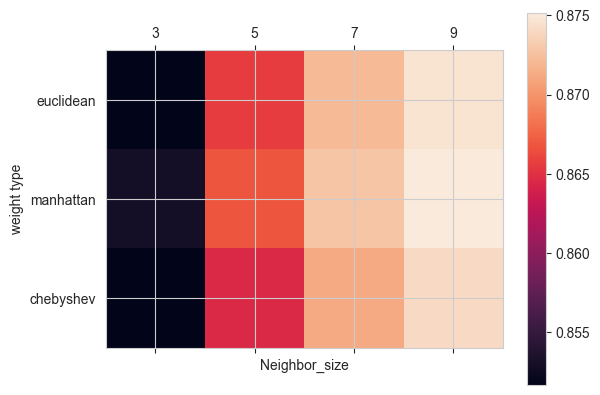

In [20]:
knn = KNeighborsClassifier()
neighbor_size = [3,5,7,9]
metric = ["euclidean","manhattan","chebyshev"]
mat = np.empty([len(metric),len(neighbor_size)])
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, shuffle=True)
for k in metric:
    for neighbors in neighbor_size:
        knn = KNeighborsClassifier(n_neighbors=neighbors,metric=k)
        accurancy,f1 = train_model(knn,X_train,y_train,X_test,y_test,state_dic)
        mat[metric.index(k)][neighbor_size.index(neighbors)] = accurancy

plt.matshow(mat)
plt.colorbar()
plt.xlabel("Neighbor_size")
plt.ylabel("weight type")
plt.xticks(np.arange(mat.shape[1]),neighbor_size)
plt.yticks(np.arange(mat.shape[0]),metric)
plt.show()

**From the matrix we can see that the best performance comes from 9 neighbors and chebyshev distance measurement, so we will make further discussion on that. It also indicates that neighbors play important role in the model.**

accuracy is:  0.8738479414793884 , F1 score is:  0.40722642958181116
accuracy is:  0.8728559544716306 , F1 score is:  0.4096722887385878
accuracy is:  0.8725428921029235 , F1 score is:  0.40872046789809363
accuracy is:  0.8717393457234345 , F1 score is:  0.3991397949037611
accuracy is:  0.8723769483074615 , F1 score is:  0.39634642825054783
accuracy is:  0.872414688574233 , F1 score is:  0.3895850987168754
accuracy is:  0.8716833356598243 , F1 score is:  0.3739748918114861


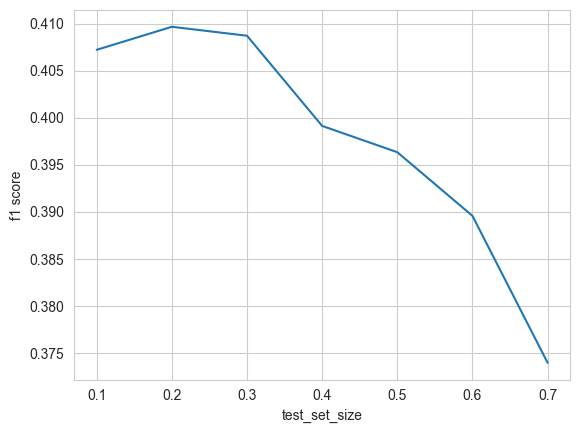

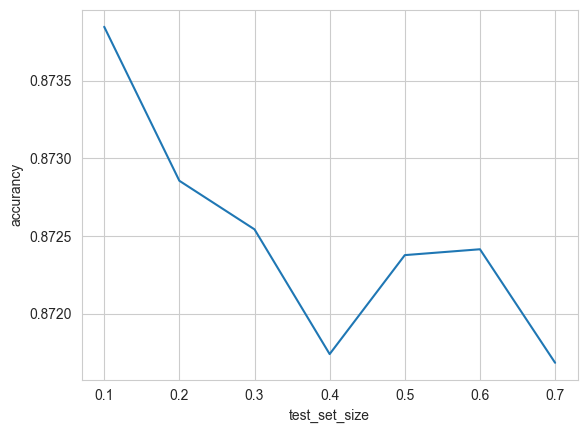

In [21]:
acc_curve = []
f1_curve = []
for x in x_axis:
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=x, shuffle=True)
    knn = KNeighborsClassifier(n_neighbors=9,metric="chebyshev")
    accurancy,f1 = train_model(knn,X_train,y_train,X_test,y_test,state_dic) 
    acc_curve.append(accurancy) 
    f1_curve.append(f1)  
show_curve(x_axis=x_axis,y_axis=f1_curve,yLabel="f1 score")
show_curve(x_axis,acc_curve)

**From result above we choose neighbors=9, chebyshev distance measurement and test size=0.3 as the best result. Then we store the f1 and accurancy in hte best case.**

In [ ]:
best_scores.append(acc_curve[2])
best_f1.append(f1_curve[2])

**The second one is GaussianNB, the processing techniques are the same as above. Due to Gaussian is based on Bayes method, it doesn't have much hyperparameters. As a result, we just use one hyperparameters-var_smoothing to experiment.**

accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371
accuracy is:  0.8738330714483779 , F1 score is:  0.3823374489974371


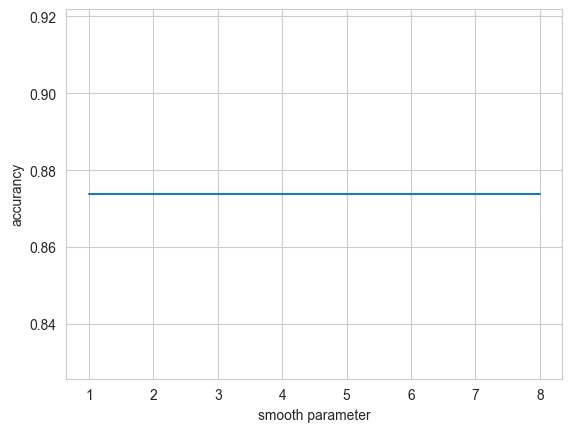

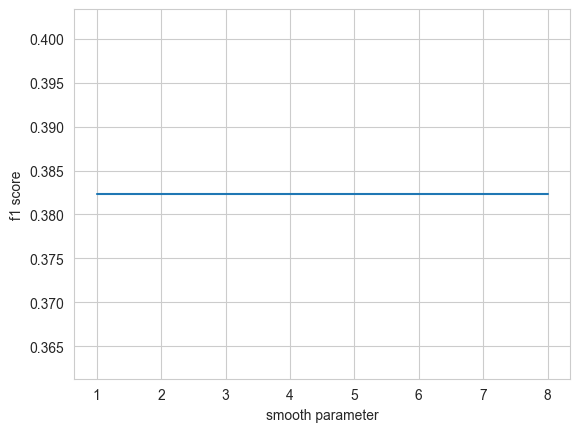

In [22]:
acc_curve = []
f1_curve = []
smoothing = [1,2,3,4,5,6,7,8]
mat = np.empty([len(metric),len(neighbor_size)])
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, shuffle=True)
for k in smoothing:
        gn = GaussianNB(var_smoothing=k*1e-9)
        accurancy,f1 = train_model(gn,X_train,y_train,X_test,y_test,state_dic)
        acc_curve.append(accurancy) 
        f1_curve.append(f1)  
show_curve(x_axis=smoothing,y_axis=acc_curve,xLabel="smooth parameter",yLabel="accurancy")
show_curve(x_axis=smoothing,y_axis=f1_curve,xLabel="smooth parameter",yLabel="f1 score")

In [23]:
X_train

,category,main_category,currency,goal,pledged,backers,country,usd pledged,earning,interval
277636,135,1,1,25000.0,138.0,3,1,138.00,-24862.00,0
160044,2,2,0,1500.0,78.0,7,0,6.34,-1745.90,30
138839,2,2,1,4000.0,0.0,0,1,0.00,-4000.00,44
165711,3,1,1,20000.0,0.0,0,1,0.00,-20000.00,59
30871,97,1,3,31500.0,110.0,4,3,78.92,-22275.05,34
...,...,...,...,...,...,...,...,...,...,...
193499,7,4,3,6000.0,6290.0,35,3,832.34,219.19,29
115204,7,4,1,50000.0,44973.0,108,1,15574.00,-5027.00,29
110391,49,12,3,110000.0,0.0,0,3,0.00,-84104.29,29
298963,19,9,0,1200.0,102.0,11,0,155.56,-1630.87,29


accuracy is:  0.8712599360921118 , F1 score is:  0.4112253952828957
accuracy is:  0.872723911636935 , F1 score is:  0.4089005346500872
accuracy is:  0.8731414889215574 , F1 score is:  0.40432826470542205
accuracy is:  0.8726966625953191 , F1 score is:  0.4041228168293984
accuracy is:  0.8725829367615446 , F1 score is:  0.39422279269209587
accuracy is:  0.8720449653824655 , F1 score is:  0.38742532198116636
accuracy is:  0.871434338251661 , F1 score is:  0.38015922962533927


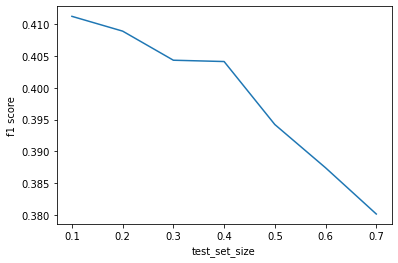

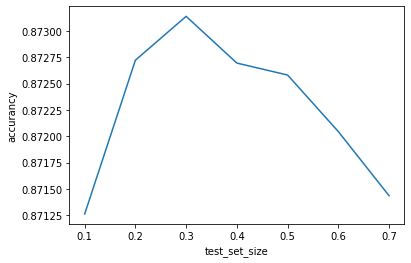

In [ ]:
acc_curve = []
f1_curve = []
for x in x_axis:
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=x, shuffle=True)
    gn = GaussianNB()
    accurancy,f1 = train_model(knn,X_train,y_train,X_test,y_test,state_dic) 
    acc_curve.append(accurancy) 
    f1_curve.append(f1)  
show_curve(x_axis=x_axis,y_axis=f1_curve,yLabel="f1 score")
show_curve(x_axis,acc_curve)

In [ ]:
best_scores.append(acc_curve[2])
best_f1.append(f1_curve[2])

The third one is random forest

accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 , F1 score is:  0.39038378460874285
accuracy is:  0.8745989198896121 ,

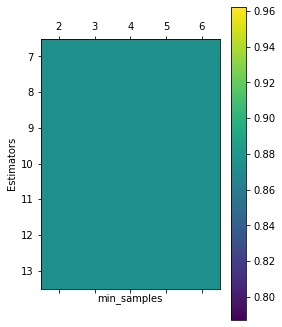

In [ ]:
rf = RandomForestClassifier(random_state=1)
estimators = [7,8,9,10,11,12,13]
min_samples = [2,3,4,5,6]
mat = np.empty([len(estimators),len(min_samples)])
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, shuffle=True)
for k in estimators:
    for sample_num in min_samples:
        rf = RandomForestClassifier(random_state=1,n_estimators=k,min_samples_split=sample_num)
        accurancy,f1 = train_model(rf,X_train,y_train,X_test,y_test,state_dic)
        mat[estimators.index(k)][min_samples.index(sample_num)] = accurancy

plt.matshow(mat)
plt.colorbar()
plt.xlabel("min_samples")
plt.ylabel("Estimators")
plt.xticks(np.arange(mat.shape[1]),min_samples)
plt.yticks(np.arange(mat.shape[0]),estimators)
plt.show()

accuracy is:  0.8727652045316503 , F1 score is:  0.41178200859884023
accuracy is:  0.8740707485508299 , F1 score is:  0.41206023084626214
accuracy is:  0.8734936046972245 , F1 score is:  0.4083937361537466
accuracy is:  0.8722411118080085 , F1 score is:  0.4013886152493136
accuracy is:  0.8717695464556782 , F1 score is:  0.39787505905521653
accuracy is:  0.8712527014001065 , F1 score is:  0.39021199730298467
accuracy is:  0.8713551118036089 , F1 score is:  0.3832667497934803


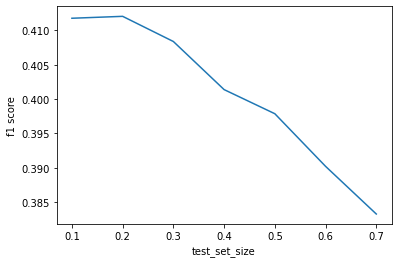

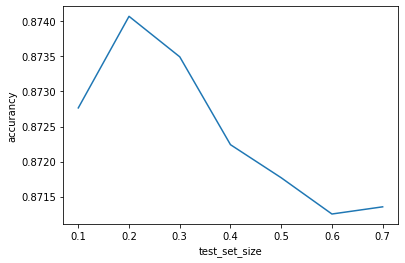

In [ ]:
acc_curve = []
f1_curve = []
for x in x_axis:
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=x, shuffle=True)
    rf = RandomForestClassifier(random_state=1)
    accurancy,f1 = train_model(knn,X_train,y_train,X_test,y_test,state_dic) 
    acc_curve.append(accurancy) 
    f1_curve.append(f1)  
show_curve(x_axis=x_axis,y_axis=f1_curve,yLabel="f1 score")
show_curve(x_axis,acc_curve)

From results above, we store the best f1 and accurancy into the curve.

In [ ]:
best_scores.append(acc_curve[1])
best_f1.append(f1_curve[1])

We also use voting system as a resemble to improve the accuracy

accuracy is:  0.8713551118036089 , F1 score is:  0.3832667497934803
accuracy is:  0.8727387963134128 , F1 score is:  0.38356340626719004
accuracy is:  0.8746253284565513 , F1 score is:  0.39185944524932564
accuracy is:  0.8737136770570163 , F1 score is:  0.38970669523760293
accuracy is:  0.8741491433664543 , F1 score is:  0.38812237226756513
accuracy is:  0.8742995072122368 , F1 score is:  0.38759195181962536
accuracy is:  0.8738099534764984 , F1 score is:  0.3915377166332084
accuracy is:  0.8736074065410865 , F1 score is:  0.3909363237402738


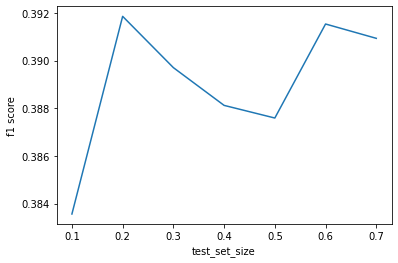

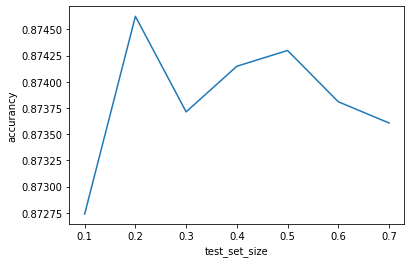

In [ ]:
voting = VotingClassifier(estimators=[('knn',knn),('gaussian',gn),('random forest',rf)],voting='hard')
acc_curve = []
f1_curve = []
train_model(rf,X_train,y_train,X_test,y_test,state_dic)
for size in x_axis:
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=size, shuffle=True)
    accurancy,f1 = train_model(voting,X_train,y_train,X_test,y_test,state_dic)
    acc_curve.append(accurancy)
    f1_curve.append(f1)
show_curve(x_axis=x_axis,y_axis=f1_curve,yLabel="f1 score")
show_curve(x_axis,acc_curve)


In [ ]:
best_scores.append(acc_curve[1])
best_f1.append(f1_curve[1])

0.8741491433664543


Finally let's compare those best results and f1 score

[0.8729390223505489, 0.8752591340630901, 0.8727652045316503, 0.8741491433664543]


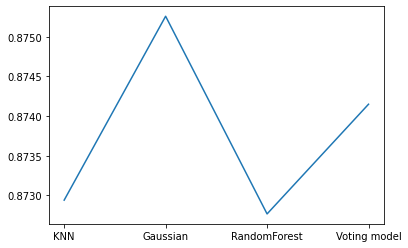

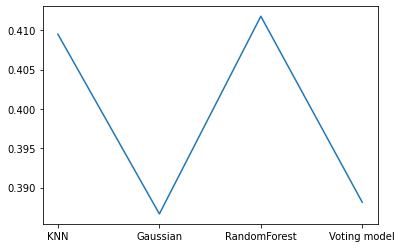

In [ ]:
sorts = ['KNN','Gaussian','RandomForest','Voting model']
plt.plot(sorts,best_scores)
plt.show()
plt.plot(sorts,best_f1)
plt.show()